In [2]:
import pygame
import numpy as np
import random
import time

COLOR_BG = (10, 10, 10) 
COLOR_GRID = (40, 40, 40) 
COLOR_DIE_NEXT = (170, 170, 170) 
COLOR_ALIVE_NEXT = (255, 255, 255)

#ASSIGNEMENTS
PATTERNS = {
    "block": np.array([[1,1], [1,1]]),  #Still Life
    "blinker": np.array([[1,1,1]]),  #Oscillator
    "glider": np.array([[0,0,1], [1,0,1], [0,1,1]]),  #Spaceship
    "eater_one": np.array([[1,1,0,0], [1,0,1,0], [0,0,1,0], [0,0,1,1]]), #Still Life
    "herschel": np.array([[1,0,0], [1,1,1], [1,0,1], [0,0,1]]), #Methuselah (Advanced pattern)
    "switch_engine": np.array([[0,1,0,1,0,0], [1,0,0,0,0,0], [0,1,0,0,1,0], [0,0,0,1,1,1]]), #Methuselah (Advanced pattern)
    "gosper_glider_gun": np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) #Gun (Advanced pattern)
}

def update(screen, cells, size, with_progress=False):
    update_cells = np.zeros(cells.shape, dtype=int)
    rows, cols = cells.shape
    
    for row, col in np.ndindex(cells.shape):
        alive = sum(
            cells[(row + i) % rows, (col + j) % cols]
            for i in [-1, 0, 1]
            for j in [-1, 0, 1]
            if not (i == 0 and j == 0)
        )
        
        color = COLOR_BG if cells[row, col] == 0 else COLOR_ALIVE_NEXT
        
        if cells[row, col] == 1:
            if alive < 2 or alive > 3:
                if with_progress:
                    color = COLOR_DIE_NEXT
            elif 2 <= alive <= 3:
                update_cells[row, col] = 1
                if with_progress:
                    color = COLOR_ALIVE_NEXT
        else:
            if alive == 3:
                update_cells[row, col] = 1
                if with_progress:
                    color = COLOR_ALIVE_NEXT
        
        pygame.draw.rect(screen, color, (col * size, row * size, size - 1, size - 1))
    
    return update_cells

def reset(cells, rows, cols, sigma=5):
    m = 3  # Numero di centri gaussiani
    centers = np.column_stack((np.random.randint(0, rows, size=m), np.random.randint(0, cols, size=m)))
    prob_grid = np.zeros(cells.shape)
    for center in centers:
        distance_squared = (np.indices(cells.shape)[0] - center[0])**2 + (np.indices(cells.shape)[1] - center[1])**2
        prob_grid += np.exp(-distance_squared / (2 * sigma**2))
    prob_grid /= prob_grid.max()
    cells[:, :] = np.random.rand(rows, cols) < prob_grid
    return cells  # Aggiunto il return della matrice aggiornata



def generate_random(cells):
    cells[:, :] = np.random.randint(0, 20, size=cells.shape)
    return cells

def insert_pattern(cells, pattern_name, x, y):
    pattern = PATTERNS.get(pattern_name)
    if pattern is not None:
        rows, cols = pattern.shape
        cells[x:x+rows, y:y+cols] = pattern
    return cells

def main():
    pygame.init()
    screen = pygame.display.set_mode((1200, 600))
    clock = pygame.time.Clock()
    cells = np.zeros((80, 120))  
    size = 10  
    screen.fill(COLOR_GRID)
    rows, cols = 80, 120
    cells = np.zeros((rows, cols), dtype=int)
    reset(cells, rows, cols)  # Reset con la nuova funzionalità gaussiana
    update(screen, cells, size)
    pygame.display.flip()
    
    running = False
    drawing = False
    selected_pattern = "glider"  

    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    running = not running
                elif event.key == pygame.K_q: 
                    cells = reset(cells, rows, cols)  # La funzione reset restituisce ora la matrice aggiornata

                elif event.key == pygame.K_g:  
                    cells = generate_random(cells)
                    update(screen, cells, size)
                    pygame.display.update()
                elif event.key == pygame.K_1:
                    selected_pattern = "block" #key1 to print block 
                elif event.key == pygame.K_2:
                    selected_pattern = "blinker" #key2 to print blinker 
                elif event.key == pygame.K_3:
                    selected_pattern = "glider" #key3 to print glider 
                elif event.key == pygame.K_4:
                    selected_pattern = "eater_one" #key4 to print eater 1 
                elif event.key == pygame.K_5:
                    selected_pattern = "herschel" #key5 to print herschel 
                elif event.key == pygame.K_6:
                    selected_pattern = "switch_engine" #key6 to print switch engine 
                elif event.key == pygame.K_7:
                    selected_pattern = "gosper_glider_gun" #key7 to print gosper glider gun 
            elif event.type == pygame.MOUSEBUTTONDOWN:
                pos = pygame.mouse.get_pos()
                row,col= pos[1]// size, pos[0]//size  #Convert pixels coordinates to grid index  
                if event.button == 1:
                    drawing = True
                    cells[row, col] = 1
                elif event.button == 3:  #Right-click=insert the selected pattern
                    cells = insert_pattern(cells, selected_pattern, row, col)
            elif event.type == pygame.MOUSEBUTTONUP and event.button == 1:
                drawing = False
            elif event.type == pygame.MOUSEMOTION and drawing:
                pos = pygame.mouse.get_pos()
                row,col =pos[1]//size,pos[0]//size
                cells[row,col] = 1  

        screen.fill(COLOR_GRID)
        if running:
            cells = update(screen, cells, size, with_progress=True)
        else:
            update(screen, cells, size)

        pygame.display.update()
        clock.tick(10)
        time.sleep(0.001)

if __name__ == '__main__':
    main()

pygame 2.6.1 (SDL 2.28.4, Python 3.11.6)
,Hello from the pygame community. https://www.pygame.org/contribute.html


pygame-ce 2.4.1 (SDL 2.28.4, Python 3.12.7)


Matplotlib is building the font cache; this may take a moment.


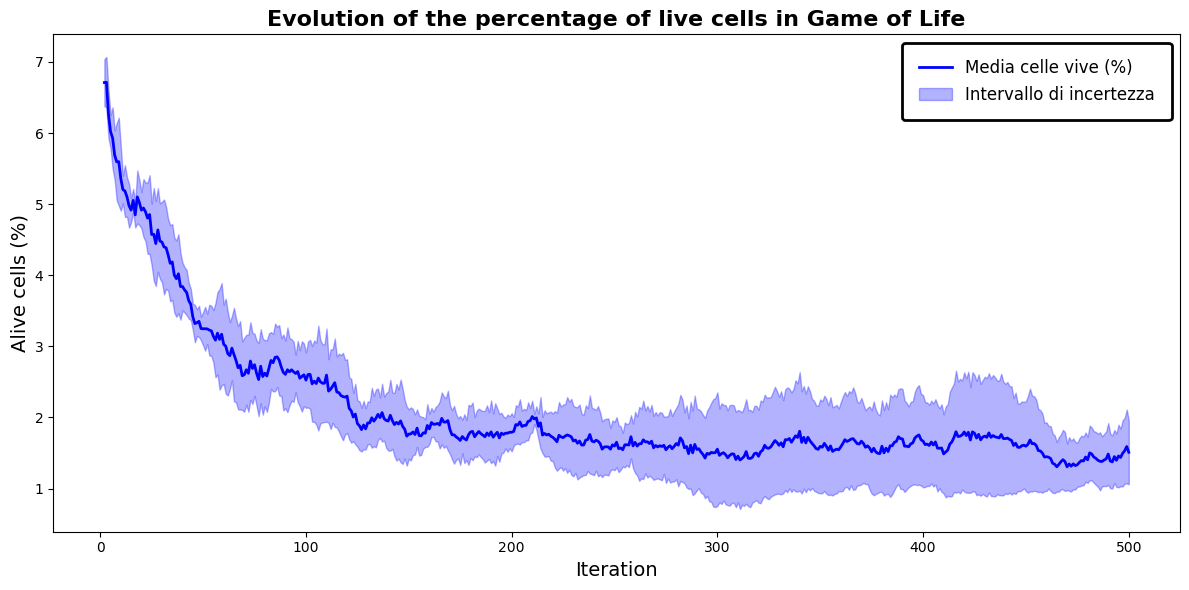

In [1]:
import pygame
import numpy as np
import random
import time
import matplotlib.pyplot as plt

def update(cells):
    update_cells = np.zeros(cells.shape, dtype=int)
    rows, cols = cells.shape
    for row, col in np.ndindex(cells.shape):
        alive = sum(
            cells[(row + i) % rows, (col + j) % cols]
            for i in [-1, 0, 1]
            for j in [-1, 0, 1]
            if not (i == 0 and j == 0)
        )
        if cells[row, col] == 1:
            if alive < 2 or alive > 3:
                update_cells[row, col] = 0
            elif 2 <= alive <= 3:
                update_cells[row, col] = 1
        elif alive == 3:
            update_cells[row, col] = 1
    return update_cells

def simulate_iterations(rows, cols, iterations=1000, max_steps=100):
    all_live_counts = []
    
    for _ in range(iterations):
        # Inizializza la griglia
        cells = np.zeros((rows, cols), dtype=int)
        generate_random(cells)
        
        live_counts = []
        for step in range(max_steps):
            cells = update(cells)
            live_count = np.sum(cells)  # Conta le celle vive
            live_counts.append(live_count)
        
        all_live_counts.append(live_counts)
    
    # Calcolare la media e la deviazione standard
    all_live_counts = np.array(all_live_counts)
    mean_live_counts = np.mean(all_live_counts, axis=0)
    std_live_counts = np.std(all_live_counts, axis=0)
    
    return mean_live_counts, std_live_counts
def generate_random(cells):
    cells[:, :] = np.random.randint(0, 2, size=cells.shape)
    return cells



def plot_live_cells(mean_live_counts, std_live_counts, total_cells):
    # Calcolare la percentuale di celle vive rispetto al totale delle celle
    mean_live_percent = (mean_live_counts / total_cells) * 100
    std_live_percent = (std_live_counts / total_cells) * 100

    # Iterazioni (a partire dall'iterazione 2)
    iterations = np.arange(2, len(mean_live_percent) + 1)

    plt.figure(figsize=(12, 6))  # Dimensione più grande per un grafico professionale
    plt.plot(iterations, mean_live_percent[1:], label="Media celle vive (%)", color="b", linewidth=2)
    plt.fill_between(iterations, 
                     mean_live_percent[1:] - std_live_percent[1:], 
                     mean_live_percent[1:] + std_live_percent[1:], 
                     color="b", alpha=0.3, label="Intervallo di incertezza")

    # Miglioramenti estetici
    plt.title('Evolution of the percentage of live cells in Game of Life', fontsize=16, fontweight='bold')
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Alive cells (%)', fontsize=14)

    # Legenda con bordi spessi
    legend = plt.legend(frameon=True, fontsize=12, borderpad=1, loc='upper right', fancybox=True, framealpha=1, edgecolor='black')
    legend.get_frame().set_linewidth(2)  # Imposta lo spessore del bordo della legenda

    # Rimuovere la griglia
    plt.grid(False)

    # Aggiungere margini per un aspetto migliore
    plt.tight_layout()

    # Visualizzare il grafico
    plt.show()




# Simula e visualizza i risultati
rows, cols = 50, 50  # Dimensioni della griglia
iterations = 5  # Numero di simulazioni
max_steps = 500  # Numero massimo di passi per simulazione
total_cells= 9600
mean_live_counts, std_live_counts = simulate_iterations(rows, cols, iterations, max_steps)
plot_live_cells(mean_live_counts, std_live_counts, total_cells)

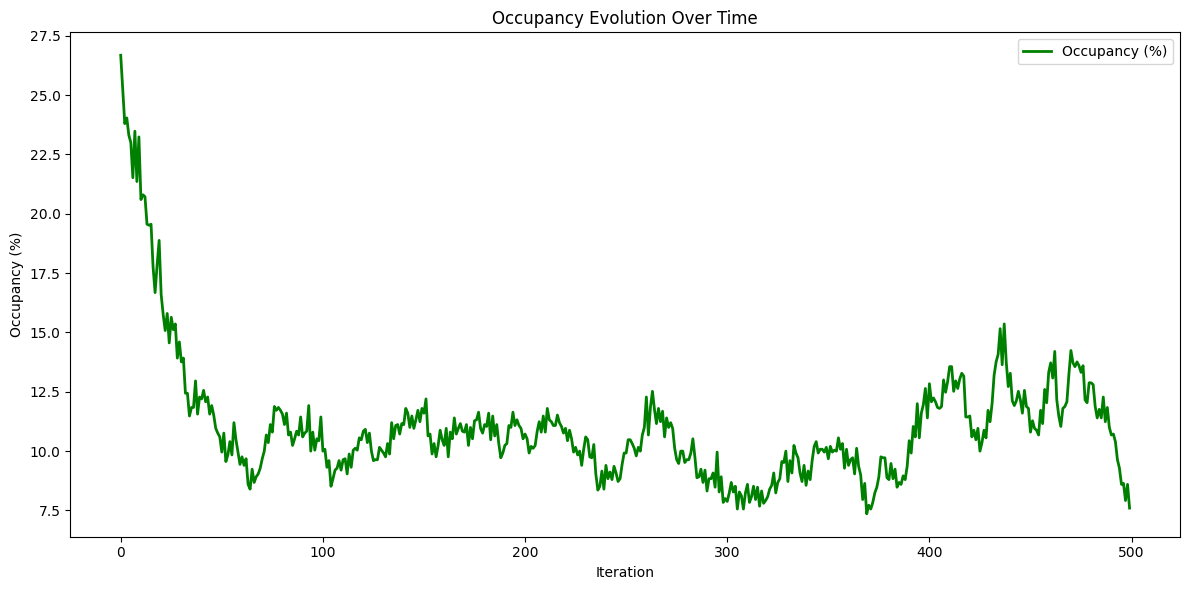

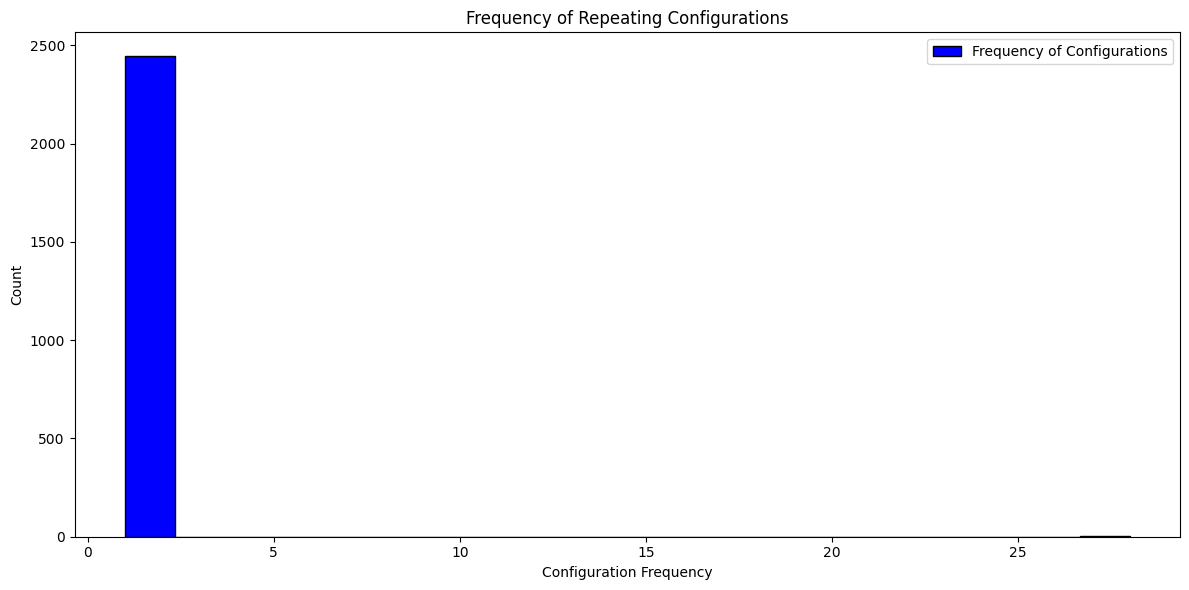

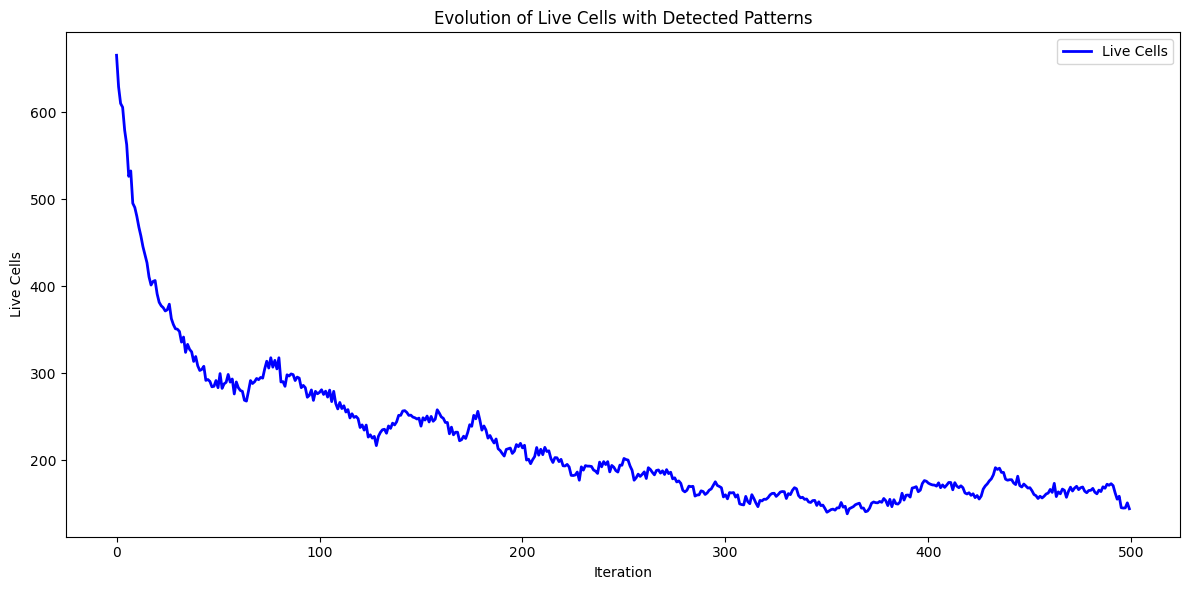

In [4]:
import matplotlib.pyplot as plt

import numpy as np

# Predefined patterns (you can expand this as needed)
PATTERNS = {
    "block": np.array([[1,1], [1,1]]),  #Still Life
    "blinker": np.array([[1,1,1]]),  #Oscillator
    "glider": np.array([[0,0,1], [1,0,1], [0,1,1]]),  #Spaceship
    "eater_one": np.array([[1,1,0,0], [1,0,1,0], [0,0,1,0], [0,0,1,1]]), #Still Life
    "herschel": np.array([[1,0,0], [1,1,1], [1,0,1], [0,0,1]]), #Methuselah (Advanced pattern)
    "switch_engine": np.array([[0,1,0,1,0,0], [1,0,0,0,0,0], [0,1,0,0,1,0], [0,0,0,1,1,1]]), #Methuselah (Advanced pattern)
    "gosper_glider_gun": np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) #Gun (Advanced pattern)
}



def track_frequency(cells, history, max_steps):
    """ Track frequency of repeating configurations """
    config = tuple(cells.flatten())  # Flatten the grid to a 1D array and convert to tuple for comparison
    if config in history:
        history[config] += 1
    else:
        history[config] = 1

    if len(history) > max_steps:
        history = {k: v for k, v in history.items() if v < max_steps}  # Keep history size manageable
    
    return history

def track_replication(cells, pattern, previous_cells, detected_patterns):
    """ Track replication of specific patterns (e.g., gliders, spaceships) """
    if np.array_equal(cells, previous_cells):  # If the pattern didn't change, no replication
        return detected_patterns

    for pattern_name, pattern_grid in PATTERNS.items():
        if np.array_equal(cells, pattern_grid):  # If a specific pattern appears
            detected_patterns.append(pattern_name)

    return detected_patterns

def track_occupancy(cells, total_cells, step, occupancy_history):
    """ Track the occupancy percentage of the grid over time """
    live_cells = np.sum(cells)  # Count live cells
    occupancy_percentage = (live_cells / total_cells) * 100
    occupancy_history[step] = occupancy_percentage
    return occupancy_history

def simulate_and_analyze(rows, cols, iterations=1000, max_steps=100):
    all_live_counts = []
    occupancy_history = {}
    frequency_history = {}
    detected_patterns = []
    
    for _ in range(iterations):
        # Initialize the grid and set it to a random state
        cells = np.zeros((rows, cols), dtype=int)
        generate_random(cells)

        live_counts = []
        previous_cells = np.zeros((rows, cols), dtype=int)
        
        for step in range(max_steps):
            cells = update(cells)  # Update the grid
            live_count = np.sum(cells)  # Count live cells
            live_counts.append(live_count)

            # Track occupancy and frequency
            occupancy_history = track_occupancy(cells, rows * cols, step, occupancy_history)
            frequency_history = track_frequency(cells, frequency_history, max_steps)
            detected_patterns = track_replication(cells, PATTERNS, previous_cells, detected_patterns)

            previous_cells = np.copy(cells)  # Store the previous state for replication check
        
        all_live_counts.append(live_counts)
    
    return all_live_counts, occupancy_history, frequency_history, detected_patterns

def plot_occupancy(occupancy_history, total_cells):
    # Plot occupancy over time
    iterations = list(occupancy_history.keys())
    occupancy_percent = [occupancy_history[step] for step in iterations]

    plt.figure(figsize=(12, 6))
    plt.plot(iterations, occupancy_percent, label="Occupancy (%)", color="g", linewidth=2)
    plt.title("Occupancy Evolution Over Time")
    plt.xlabel("Iteration")
    plt.ylabel("Occupancy (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_frequency(frequency_history):
    # Plot frequency of recurring configurations
    configurations = list(frequency_history.values())
    plt.figure(figsize=(12, 6))
    plt.hist(configurations, bins=20, label="Frequency of Configurations", color="b", edgecolor="black")
    plt.title("Frequency of Repeating Configurations")
    plt.xlabel("Configuration Frequency")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_live_cells_and_patterns(live_counts, detected_patterns):
    # Plot live cells and detected patterns
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(live_counts)), live_counts, label="Live Cells", color="b", linewidth=2)
    
    # Highlight detected patterns
    for pattern in set(detected_patterns):
        plt.axvline(x=detected_patterns.index(pattern), label=f"Pattern: {pattern}", linestyle="--")
    
    plt.title("Evolution of Live Cells with Detected Patterns")
    plt.xlabel("Iteration")
    plt.ylabel("Live Cells")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run simulation and analyze
rows, cols = 50, 50  # Grid dimensions
iterations = 5  # Number of simulations
max_steps = 500  # Maximum steps for each simulation
all_live_counts, occupancy_history, frequency_history, detected_patterns = simulate_and_analyze(rows, cols, iterations, max_steps)

# Plot occupancy, frequency, and live cells
plot_occupancy(occupancy_history, rows * cols)
plot_frequency(frequency_history)
plot_live_cells_and_patterns(np.mean(all_live_counts, axis=0), detected_patterns)
